-----------

# READING AND CLEANING DATA FROM ACADEMIC TORRENTS

### IMPORTS AND FUNCTIONS

In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# UNCOMMENT IF THE networkx package is not installed (not necessary for main analysis)
# !pip install networkx
import networkx as nx

In [56]:
def clean_reddit_data(df):
    """
    Input: raw dataframe from academic torrents
    Output: clean dataframe, with no missing.

    """

    # GETTING POST ID
    df["post_id"] = df["URL"].apply(lambda x: "".join(re.findall("(?<=comments\/)\w+(?=\/)",x))).copy()
    df.URL = df.URL.apply(lambda x: "".join(re.findall(r"r\/\w+",x)))

    #REMOVE MISSING VALUES AND TAKE ONLY DATA FROM OUR SUBREDDITS
    list_subreddit = ["r/Judaism","r/IsraelPalestine","r/Israel","r/Palestine","r/Jewish"]
    df = df[
            (df["URL"].isin(list_subreddit))
            & (df["text"] != "[removed]")
            & (df["text"] != "[deleted]") 
            & (~df["text"].isna())
            ].drop_duplicates()
    # REMOVE POSTS WHICH CONTAIN ONLY IMAGES OR URLS
    df = df[(df.text.str.contains(" ")) & (~df.text.str.contains("https://"))]

    # RENAME COLUMNS
    df = df.rename(columns= {"URL": "subreddit"})

    return df.sort_values("date").reset_index(drop = True)

In [57]:
def clean_reddit_data_rem_del(df):
    """
    Input: raw dataframe from academic torrents
    Output: clean dataframe which contains also removed and deleted posts for visualization purposes.

    """

    # GETTING POST ID
    df["post_id"] = df["URL"].apply(lambda x: "".join(re.findall("(?<=comments\/)\w+(?=\/)",x))).copy()
    df.URL = df.URL.apply(lambda x: "".join(re.findall(r"r\/\w+",x)))

    #REMOVE MISSING VALUES AND TAKE ONLY DATA FROM OUR SUBREDDITS
    list_subreddit = ["r/Judaism","r/IsraelPalestine","r/Israel","r/Palestine","r/Jewish"]
    df = df[
            (df["URL"].isin(list_subreddit))
            ].drop_duplicates()
    # REMOVE POSTS WHICH CONTAIN ONLY IMAGES OR URLS
    df.text = df.text.fillna("NaN")
    # RENAME COLUMNS
    df = df.rename(columns= {"URL": "subreddit"})

    return df.sort_values("date").reset_index(drop = True)

### READING IN THE DATA AND CLEANING

In [58]:
list_dataframes_23 = [clean_reddit_data(pd.read_csv(f"Reddit0{x}23.csv")) if x < 10 else clean_reddit_data(pd.read_csv(f"Reddit{x}23.csv")) for x in range(7,13)]
list_dataframes_24 = [clean_reddit_data(pd.read_csv(f"Reddit0{x}24.csv")) for x in range(1,5)]
list_dataframes = list_dataframes_23 + list_dataframes_24

In [59]:
final = pd.concat(list_dataframes, axis = 0, ignore_index = True).reset_index(drop = True)

In [159]:
#TO SAVE
final.to_csv("RedditSubmissionsClean.csv")

## VISUALIZATION

### Removed and Deleted

In [61]:
# READ THE DATASETS AGAIN WITHOUT REMOVING DELETED AND REMOVED SUBMISSIONS IN ORDER TO VISUALIZE
list_dataframes_23_2 = [clean_reddit_data_rem_del(pd.read_csv(f"Reddit0{x}23.csv")) if x < 10 else clean_reddit_data_rem_del(pd.read_csv(f"Reddit{x}23.csv")) for x in range(7,13)]
list_dataframes_24_2 = [clean_reddit_data_rem_del(pd.read_csv(f"Reddit0{x}24.csv")) for x in range(1,5)]
list_dataframes_2 = list_dataframes_23_2 + list_dataframes_24_2

final_2 = pd.concat(list_dataframes_2, axis = 0, ignore_index = True).reset_index(drop = True)
subset = ["r/Israel","r/IsraelPalestine","r/Palestine"]
removed = pd.DataFrame(final_2[((final_2.text == "[removed]") | (final_2.text == "[deleted]")) & (final_2.subreddit.isin(subset))].groupby(["subreddit","text"])["post_id"].count()).rename(columns = {"post_id":"Number of Deleted and Removed Posts"})
removed.to_latex("table2.tex")
removed

Number of Deleted and Removed Posts
subreddit         text                                          
r/Israel          [deleted]                                   52
                  [removed]                                 4044
r/IsraelPalestine [deleted]                                   22
                  [removed]                                 9273
r/Palestine       [deleted]                                   15
                  [removed]                                 8773

### Total posts

In [5]:
final.groupby("subreddit")["text"].apply("count").reset_index().rename(columns = {"text" : "Number of Total Posts"})

,subreddit,Number of Total Posts
0,r/Israel,5960
1,r/IsraelPalestine,6667
2,r/Jewish,4666
3,r/Judaism,7307
4,r/Palestine,1412


### Posts by subreddit and month

In [7]:
final.date = [pd.to_datetime(x) for x in final.date] # change date to pandas format

In [8]:
# Create grouping temportal variables
final["year"] = [str(x.year) for x in final.date]
final["month"] = [str(x.month) if x.month > 9 else "0" + str(x.month) for x in final.date]

In [9]:
# group data by month and subreddit
grouped_df = pd.DataFrame(final.groupby(["year","month","subreddit"])["text"].count()).reset_index()
grouped_df["month_year"] = grouped_df.month + "-" + grouped_df.year

In [10]:
# Pivot the data
list_2024 = ['01-2024', '02-2024', '03-2024', '04-2024']
list_2023 = ['07-2023', '08-2023','09-2023', '10-2023', '11-2023', '12-2023']
pivot_df = grouped_df.pivot(index="month_year", columns="subreddit", values="text").sort_values("month_year")
piv = pd.concat([pivot_df.loc[list_2023,:],pivot_df.loc[list_2024,:]], axis = 0)
piv = piv.drop(["r/Judaism","r/Jewish"],axis = 1)

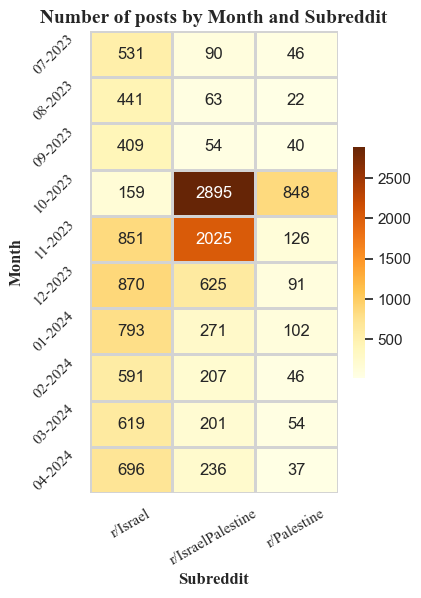

In [26]:
# MAKE HEAT MAP 

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.titlesize': 18,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

csfont = {'fontname':'Times New Roman', "fontsize": 14, "fontweight": "bold"}

# Applying Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Plotting the heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(piv, annot=True, fmt="d", cmap="YlOrBr", linewidths = 2, linecolor='lightgray', cbar_kws={'shrink': 0.5})
plt.title("Number of posts by Month and Subreddit", **csfont)
plt.xlabel("Subreddit",{"fontname": "Times New Roman", "fontsize": 12, "fontweight" : "bold"})
plt.ylabel("Month", {"fontname": "Times New Roman", "fontsize": 12,"fontweight" : "bold"})
plt.yticks(rotation=45,fontname = "Times New Roman")
plt.xticks(rotation=30, fontname = "Times New Roman")
plt.savefig("heatmap_short.png",dpi = 1000,bbox_inches = 'tight')
plt.show()

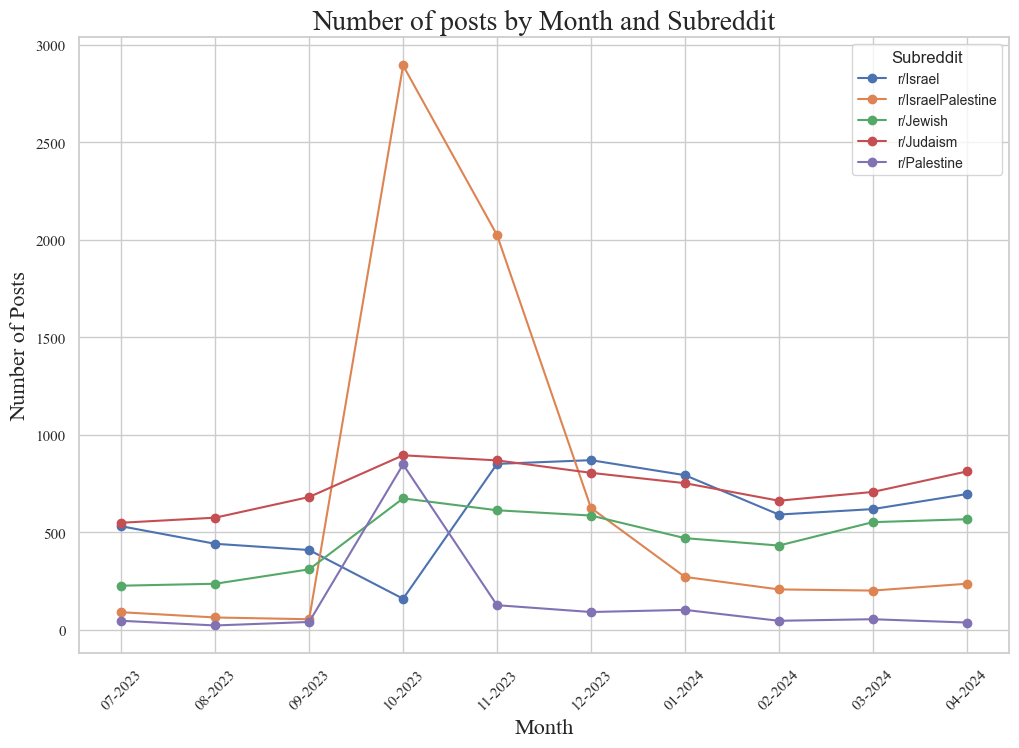

In [286]:
# TIME TRENDS PLOT
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.titlesize': 18,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

csfont = {'fontname': 'Times New Roman', "fontsize": 20}

# Applying Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Plotting the trend lines
plt.figure(figsize=(12, 8))

# Plot trend lines for each subreddit
for subreddit in piv.columns:
    plt.plot(piv.index, piv[subreddit], marker='o', label=subreddit)

# Adding title and labels
plt.title("Number of posts by Month and Subreddit", **csfont)
plt.xlabel("Month", {"fontname": "Times New Roman", "fontsize": 16})
plt.ylabel("Number of Posts", {"fontname": "Times New Roman", "fontsize": 16})
plt.xticks(rotation=45, fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")

# Adding legend
plt.legend(title="Subreddit", title_fontsize=12, fontsize=10)

# Saving the plot
#plt.savefig("trend_lines.png", dpi=1200)

# Display the plot
plt.show()

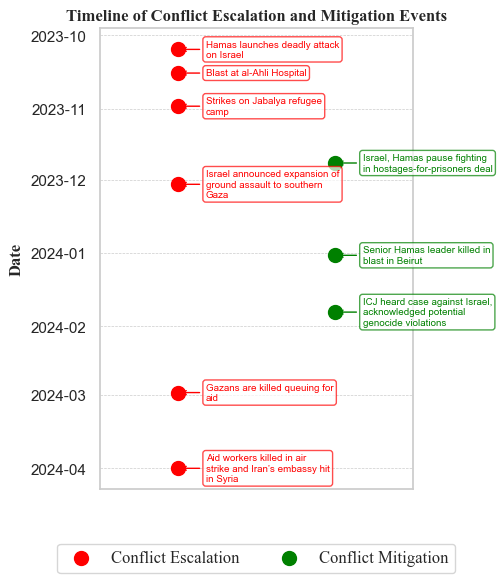

In [102]:
# TIMELINE OF EVENTS
import textwrap

# Create the data for events
events = {
    'Date': [
        '2023-10-07', '2023-10-17', '2023-10-31', '2023-12-03', '2024-02-29', '2024-04-01',
        '2023-11-24', '2024-01-02', '2024-01-26'
    ],
    'Event': [
        'Hamas launches deadly attack on Israel', 'Blast at al-Ahli Hospital', 'Strikes on Jabalya refugee camp',
        'Israel announced expansion of ground assault to southern Gaza', 'Gazans are killed queuing for aid',
        'Aid workers killed in air strike and Iran’s embassy hit in Syria',
        'Israel, Hamas pause fighting in hostages-for-prisoners deal', 'Senior Hamas leader killed in blast in Beirut',
        'ICJ heard case against Israel, acknowledged potential genocide violations'
    ],
    'Type': [
        'Escalation', 'Escalation', 'Escalation', 'Escalation', 'Escalation', 'Escalation',
        'Mitigation', 'Mitigation', 'Mitigation'
    ]
}

df = pd.DataFrame(events)
df['Date'] = pd.to_datetime(df['Date'])

# Define a function to wrap text longer than five words
def wrap_text(text, width=30):
    return '\n'.join(textwrap.wrap(text, width=width))

# Apply the wrap_text function to the 'Event' column
df['Event'] = df['Event'].apply(lambda x: wrap_text(x, width=30))

# Separate escalation and mitigation events
esc_df = df[df['Type'] == 'Escalation']
mit_df = df[df['Type'] == 'Mitigation']

# Plot the timeline
fig, ax = plt.subplots(figsize=(5, 6))

# Plot the escalation events
ax.scatter([1] * len(esc_df), esc_df['Date'], color='red', s=100, label='Conflict Escalation')
for i, row in esc_df.iterrows():
    ax.annotate(row['Event'], (1, row['Date']), xytext=(20, 0), fontsize=7,  # reduced font size
                textcoords='offset points', ha='left', va='center', color='red',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.7),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='red'))

# Plot the mitigation events
ax.scatter([2] * len(mit_df), mit_df['Date'], color='green', s=100, label='Conflict Mitigation')
for i, row in mit_df.iterrows():
    ax.annotate(row['Event'], (2, row['Date']), xytext=(20, 0), fontsize=7,  # reduced font size
                textcoords='offset points', ha='left', va='center', color='green',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white', alpha=0.7),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='green'))

# Format the plot
ax.set_xlim(0.5, 2.5)
ax.set_xticks([])
ax.set_ylabel('Date', fontweight = "bold",fontname = "Times New Roman")
ax.set_title('Timeline of Conflict Escalation and Mitigation Events', fontsize=12, fontweight = "bold", fontname = "Times New Roman")
ax.invert_yaxis()  

# Place the legend below the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=True, ncol=2, prop={'family': 'Times New Roman', 'size': 12})

# Add grid and improve layout
ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.tight_layout()
plt.savefig("timeline.png",dpi = 1000, bbox_inches = 'tight')
plt.show()


Workflow chart

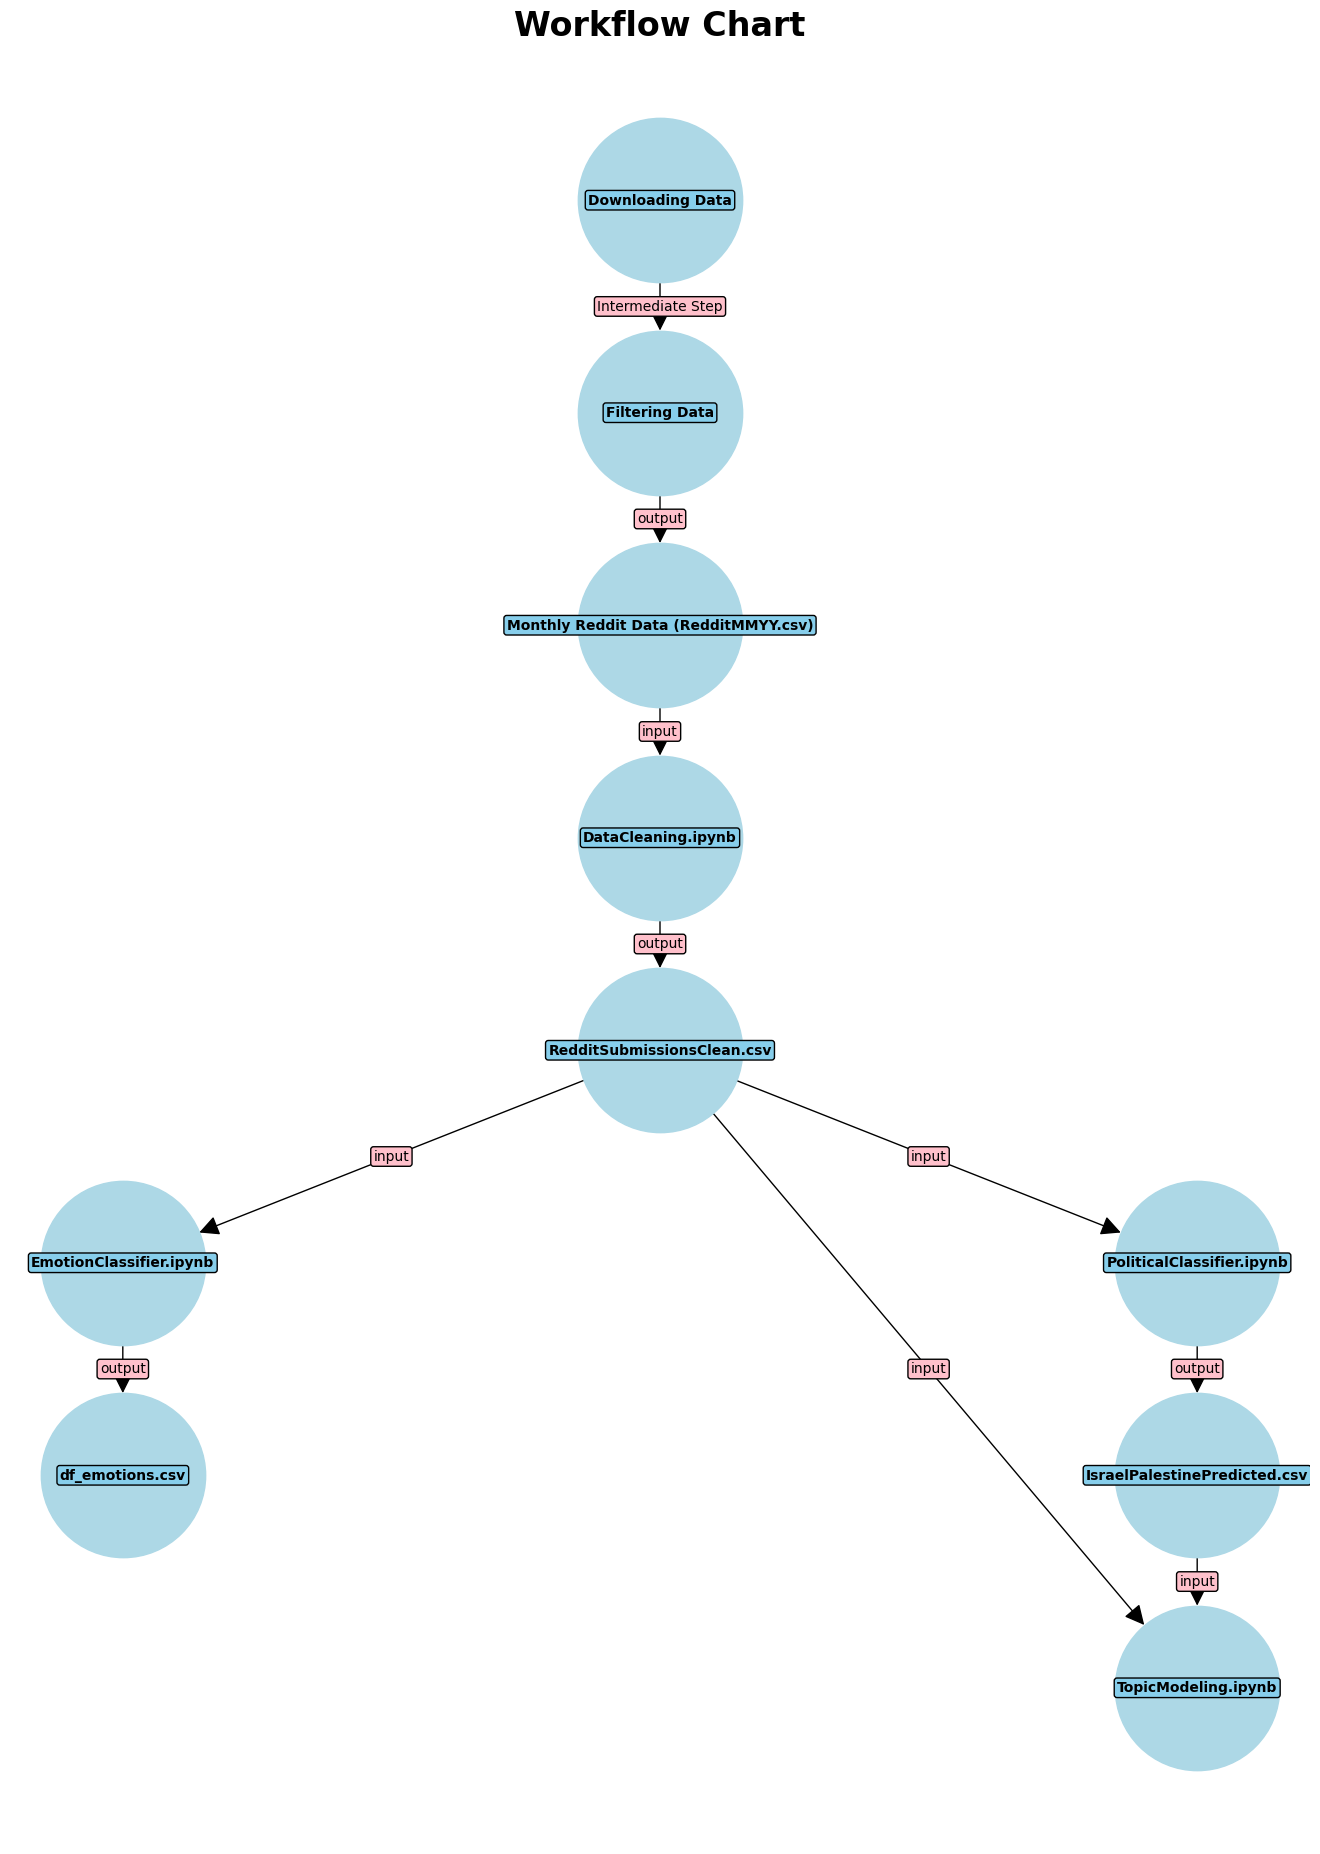

In [65]:
# Create a directed graph
G = nx.DiGraph()

# Define nodes
nodes = [
    "Downloading Data",
    "Filtering Data",
    "Monthly Reddit Data (RedditMMYY.csv)",
    "DataCleaning.ipynb",
    "RedditSubmissionsClean.csv",
    "EmotionClassifier.ipynb",
    "PoliticalClassifier.ipynb",
    "df_emotions.csv",
    "IsraelPalestinePredicted.csv",
    "TopicModeling.ipynb"
]

# Add nodes to the graph
G.add_nodes_from(nodes)

# Define edges
edges = [
    ("Downloading Data", "Filtering Data",{"label": "Intermediate Step"}),
    ("Filtering Data", "Monthly Reddit Data (RedditMMYY.csv)",{"label": "output"}),
    ("Monthly Reddit Data (RedditMMYY.csv)", "DataCleaning.ipynb",{"label": "input"}),
    ("DataCleaning.ipynb", "RedditSubmissionsClean.csv",{"label": "output"}),
    ("RedditSubmissionsClean.csv", "EmotionClassifier.ipynb",{"label": "input"}),
    ("RedditSubmissionsClean.csv", "PoliticalClassifier.ipynb",{"label": "input"}),
    ("EmotionClassifier.ipynb", "df_emotions.csv",{"label": "output"}),
    ("PoliticalClassifier.ipynb", "IsraelPalestinePredicted.csv",{"label": "output"}),
    ("IsraelPalestinePredicted.csv", "TopicModeling.ipynb",{"label": "input"}),
    ("RedditSubmissionsClean.csv", "TopicModeling.ipynb",{"label": "input"})
]

# Add edges to the graph
G.add_edges_from(edges)

# Position nodes
pos = {
    "Downloading Data": (3.5, 0),
    "Filtering Data": (3.5, -3),
    "Monthly Reddit Data (RedditMMYY.csv)" : (3.5, -6),
    "DataCleaning.ipynb": (3.5, -9),
    "RedditSubmissionsClean.csv": (3.5, -12),
    "EmotionClassifier.ipynb": (2, -15),
    "PoliticalClassifier.ipynb": (5, -15),
    "df_emotions.csv": (2, -18),
    "IsraelPalestinePredicted.csv": (5, -18),
    "TopicModeling.ipynb": (5, -21)
}

edge_labels = {(edge[0], edge[1]): attr["label"] for edge, attr in G.edges.items()}
# Draw the graph
plt.figure(figsize=(13, 18))
nx.draw(G, pos, with_labels=True, node_size=14000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True, arrowstyle='-|>' ,arrowsize=30,bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black',rotate=False,bbox=dict(facecolor="pink", edgecolor='black', boxstyle='round,pad=0.2'))

plt.savefig("workflow.png", bbox_inches = 'tight')
plt.title('Workflow Chart', fontweight = "bold", fontsize = 24)
plt.show()
